# COS 429 Final Project
## VGG Face

Initial setup:
- Create instance (p2.xlarge)
- `scp` the .caffemodel and .prototxt files over
- Create ssl cert and password for Jupyter notebook

To get this up and running on AWS (after initial setup):
- `sudo ssh -i thesis.pem -L 443:127.0.0.1:8888 ubuntu@...`
- `127.0.0.1`
- Password: cos429_russakovsky
- `source activate theano_p36`
- `conda install -c anaconda pillow`
- `conda install h5py`
- `conda install scikit-learn`
- `conda install -c pchrapka matlab_kernel`
- `jupyter notebook`
- `scp -i cos429.pem *.py ubuntu@...:~/cos429/`

This uses the Keras weights (hard to get caffemodel and t7 files working for caffe2/pytorch) for VGG_FACE, which was converted from vgg-face matconvnet model using as shown here: https://gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9.

Before stopping the instance, remember to download the latest .ipynb file for the GitHub. Terminate the instance to delete all files.

In [64]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import time
import os
import sys  
# os.environ['THEANO_FLAGS'] = "device=gpu1"    
# import theano

from keras.models import Model
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

from keras import backend as K
K.set_image_dim_ordering('th')

from PIL import Image

In [65]:
weights_path = 'vgg-face-keras.h5'

In [66]:
# This network architecture is derived from Table 3 of the CNN described in Parkhi et al. 
# and based on Keras code provided in https://gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9

def vgg_face(weights_path=None):
    img = Input(shape=(3, 224, 224))

    pad1_1 = ZeroPadding2D(padding=(1, 1))(img)
    conv1_1 = Convolution2D(64, (3, 3), activation='relu', name='conv1_1')(pad1_1)
    pad1_2 = ZeroPadding2D(padding=(1, 1))(conv1_1)
    conv1_2 = Convolution2D(64, (3, 3), activation='relu', name='conv1_2')(pad1_2)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_2)

    pad2_1 = ZeroPadding2D((1, 1))(pool1)
    conv2_1 = Convolution2D(128, (3, 3), activation='relu', name='conv2_1')(pad2_1)
    pad2_2 = ZeroPadding2D((1, 1))(conv2_1)
    conv2_2 = Convolution2D(128, (3, 3), activation='relu', name='conv2_2')(pad2_2)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_2)

    pad3_1 = ZeroPadding2D((1, 1))(pool2)
    conv3_1 = Convolution2D(256, (3, 3), activation='relu', name='conv3_1')(pad3_1)
    pad3_2 = ZeroPadding2D((1, 1))(conv3_1)
    conv3_2 = Convolution2D(256, (3, 3), activation='relu', name='conv3_2')(pad3_2)
    pad3_3 = ZeroPadding2D((1, 1))(conv3_2)
    conv3_3 = Convolution2D(256, (3, 3), activation='relu', name='conv3_3')(pad3_3)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_3)

    pad4_1 = ZeroPadding2D((1, 1))(pool3)
    conv4_1 = Convolution2D(512, (3, 3), activation='relu', name='conv4_1')(pad4_1)
    pad4_2 = ZeroPadding2D((1, 1))(conv4_1)
    conv4_2 = Convolution2D(512, (3, 3), activation='relu', name='conv4_2')(pad4_2)
    pad4_3 = ZeroPadding2D((1, 1))(conv4_2)
    conv4_3 = Convolution2D(512, (3, 3), activation='relu', name='conv4_3')(pad4_3)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_3)

    pad5_1 = ZeroPadding2D((1, 1))(pool4)
    conv5_1 = Convolution2D(512, (3, 3), activation='relu', name='conv5_1')(pad5_1)
    pad5_2 = ZeroPadding2D((1, 1))(conv5_1)
    conv5_2 = Convolution2D(512, (3, 3), activation='relu', name='conv5_2')(pad5_2)
    pad5_3 = ZeroPadding2D((1, 1))(conv5_2)
    conv5_3 = Convolution2D(512, (3, 3), activation='relu', name='conv5_3')(pad5_3)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5_3)

    # These layers are used in the original VGG Face paper for their dataset of 2,622 individuals
    # The output of the previous layer is the 4096-dimensional face descriptor
    fc6 = Convolution2D(4096, (7, 7), activation='relu', name='fc6')(pool5)
    fc6_drop = Dropout(0.5)(fc6)
    fc7 = Convolution2D(4096, (1, 1), activation='relu', name='fc7')(fc6_drop)
    fc7_drop = Dropout(0.5)(fc7)
    fc8 = Convolution2D(2622, (1, 1), name='fc8')(fc7_drop)
    flat = Flatten()(fc8)
    out = Activation('softmax')(flat)

    model = Model(inputs=img, outputs=out)

    if weights_path:
        model.load_weights(weights_path)

    return model

# Returns model that for the 4096-dimensional face descriptor 
def partial_vgg_face():
    model = vgg_face(weights_path)
    layer_name = 'fc7'
    partial_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    return partial_model

In [ ]:
# Test the model by passing an image through it
im = Image.open('A.J._Buckley.jpg')
im = im.resize((224,224))
im = np.array(im).astype(np.float32)
# im[:,:,0] -= 129.1863
# im[:,:,1] -= 104.7624
# im[:,:,2] -= 93.5940
im = im.transpose((2,0,1))
im = np.expand_dims(im, axis=0)
print('Shape:', im.shape)

model = vgg_face(weights_path)
out = model.predict(im)
print(out[0][0])

In [ ]:
# Test the partial model by passing an image through it
model = partial_vgg_face()
im = Image.open('A.J._Buckley.jpg')
im = im.resize((224,224))
im = np.array(im).astype(np.float32)
im = im.transpose((2,0,1))
im = np.expand_dims(im, axis=0)

descriptor = model.predict(im)
print(descriptor.shape)

In [67]:
model = vgg_face(weights_path)
print(model.summary())

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [68]:
% load_ext autoreload
% aimport experiment
% aimport manipulations
% autoreload 1

from sklearn.datasets import fetch_lfw_people
from scipy.spatial.distance import cosine
from scipy import ndimage
from scipy.stats import mode
import h5py

import manipulations
import experiment
from manipulations import ManipulationInfo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# Manipulations
# Based on Cathy's manipulations.py

def perform_manipulation(data, manipulation_info: ManipulationInfo):
    manipulation_type = manipulation_info.type
    manipulation_parameters = manipulation_info.parameters
    if manipulation_type == "none":
        return data
    elif manipulation_type == "occlude_lfw":
        occlusion_size = manipulation_parameters["occlusion_size"]
        return occlude_lfw_dataset(data, occlusion_size)
    elif manipulation_type == "radial_distortion":
        k = manipulation_parameters["k"]
        return radially_distort_lfw_dataset(data, k)
    elif manipulation_type == "blur":
        blurwindow_size = manipulation_parameters["blurwindow_size"]
        return blur_lfw_dataset(data, blurwindow_size)
    else:
        raise Exception("UNKNOWN MANIPULATION.")
        
def occlude_lfw_dataset(data, occlusion_size):
    num_images = data.shape[0]
    dataset_images = [add_occlusion(data[i], occlusion_size) for i in range(num_images)]
    return np.asarray(dataset_images)

def add_occlusion(input_image, occlusion_size):
    """Randomly selects an occlusion_size-by-occlusion_size square in the image
    and sets the pixels to random values between 0 and 256. Same value for all 3 channels."""
    max_value = 256
    max_i, max_j, ch = input_image.shape
    input_image = np.copy(input_image)
    start_i = np.random.randint(0, max_i-occlusion_size)
    start_j = np.random.randint(0, max_j-occlusion_size)
    occlusion_square = np.random.rand(occlusion_size, occlusion_size)*max_value
    input_image[start_i:start_i+occlusion_size,start_j:start_j+occlusion_size,0]=occlusion_square
    input_image[start_i:start_i+occlusion_size,start_j:start_j+occlusion_size,1]=occlusion_square
    input_image[start_i:start_i+occlusion_size,start_j:start_j+occlusion_size,2]=occlusion_square
    return input_image

def radially_distort_lfw_dataset(data, k):
    lfw_imageshape = (224, 224)
    distortion_array_i, distortion_array_j = create_radial_distortion_array(k, lfw_imageshape)
    num_images = data.shape[0]
    dataset_images = [radial_distortion(data[i], distortion_array_i, distortion_array_j) for i in range(num_images)]
    return np.asarray(dataset_images)

def radial_distortion(input_image, distortion_array_i, distortion_array_j):
    distorted_image = np.empty(input_image.shape)
    for i in range(distorted_image.shape[0]):
        for j in range(distorted_image.shape[1]):
            input_i = distortion_array_i[i, j]
            input_j = distortion_array_j[i, j]
            distorted_image[i,j,0] = input_image[input_i, input_j,0]
            distorted_image[i,j,1] = input_image[input_i, input_j,1]
            distorted_image[i,j,2] = input_image[input_i, input_j,2]
    return distorted_image

def create_radial_distortion_array(k, input_image_shape):
    # http://sprg.massey.ac.nz/pdfs/2003_IVCNZ_408.pdf
    # x_d = x_u / (1+kr_d^2)
    # Negative k for pincushion, positive k for barrel.
    i_max, j_max = input_image_shape
    i0 = int(i_max / 2)
    j0 = int(j_max / 2)
    distortion_array_i = np.zeros(input_image_shape, dtype='int')
    distortion_array_j = np.zeros(input_image_shape, dtype='int')
    for i in range(i_max):
        for j in range(j_max):
            i_bar = i - i0
            j_bar = j - j0
            r_squared = (i_bar * i_bar) + (j_bar * j_bar)
            i_input = i / (1+k*r_squared)
            j_input = j / (1+k*r_squared)
            if i_input < i_max and j_input < j_max and i_input >= 0 and j_input >= 0:
                distortion_array_i[i, j] = i_input
                distortion_array_j[i, j] = j_input
    return distortion_array_i, distortion_array_j

def blur_lfw_dataset(data, blurwindow_size):
    num_images = data.shape[0]
    dataset_images = [blur(data[i], blurwindow_size) for i in range(num_images)]
    return np.asarray(dataset_images)

def blur(input_image, blurwindow_size):
    blurred_image = np.empty(input_image.shape)
    blurred_image[:,:,0] = ndimage.percentile_filter(input_image[:,:,0], -50, blurwindow_size)
    blurred_image[:,:,1] = ndimage.percentile_filter(input_image[:,:,1], -50, blurwindow_size)
    blurred_image[:,:,2] = ndimage.percentile_filter(input_image[:,:,2], -50, blurwindow_size)
    return blurred_image

def blur_slow(input_image, blurwindow_size):
    blurred_image = np.empty(input_image.shape)
    blurwindow_halflength = blurwindow_size / 2
    image_imax, image_jmax = input_image.shape
    for i in range(image_imax):
        for j in range(image_jmax):
            blurwindow_imin = int(max(0, i-blurwindow_halflength))
            blurwindow_jmin = int(max(0, j-blurwindow_halflength))
            blurwindow_imax = int(min(image_imax, i+blurwindow_halflength))
            blurwindow_jmax = int(min(image_jmax, j+blurwindow_halflength))
            blurred_image[i,j,0] = np.mean(input_image[blurwindow_imin:blurwindow_imax,blurwindow_jmin:blurwindow_jmax,0])
            blurred_image[i,j,1] = np.mean(input_image[blurwindow_imin:blurwindow_imax,blurwindow_jmin:blurwindow_jmax,1])
            blurred_image[i,j,2] = np.mean(input_image[blurwindow_imin:blurwindow_imax,blurwindow_jmin:blurwindow_jmax,2])
    return blurred_image

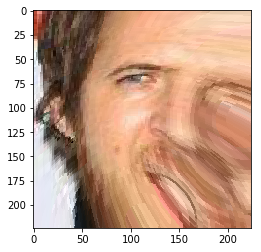

In [71]:
# Test manipulations

im = Image.open('A.J._Buckley.jpg')
im = im.resize((224,224))
im = np.array(im).astype(np.float32)
im = np.expand_dims(im, axis=0)

#         ManipulationInfo("none", {}),
#         ManipulationInfo("occlude_lfw", {"occlusion_size": 20}),
#         ManipulationInfo("occlude_lfw", {"occlusion_size": 10}),
#         ManipulationInfo("occlude_lfw", {"occlusion_size": 30}),
#         ManipulationInfo("occlude_lfw", {"occlusion_size": 40}),
#         ManipulationInfo("radial_distortion", {"k": 0.00015}),
#         ManipulationInfo("radial_distortion", {"k": -0.00015}),
#         ManipulationInfo("radial_distortion", {"k": 0.0003}),
#         ManipulationInfo("radial_distortion", {"k": -0.0003}),
#         ManipulationInfo("radial_distortion", {"k": 0.0005}),
#         ManipulationInfo("radial_distortion", {"k": -0.0005}),
#         ManipulationInfo("blur", {"blurwindow_size": 5}),
#         ManipulationInfo("blur", {"blurwindow_size": 10})

imM = perform_manipulation(im, ManipulationInfo("radial_distortion", {"k": 0.00003}))
plt.imshow(np.uint8(imM[0]))

In [79]:
def split_traintest(targets):
    # TODO: Different way of splitting train and test?
    # Maybe should use more than one of each face to train?
    """ Splits targets into train and test indices."""
    unique_targets = np.unique(targets)
    num_train = 3
    train_indices = []
    test_indices = []

    for label in unique_targets:
        label_indices = np.where(targets == label)[0].tolist()
        train_indices += label_indices[0:num_train]
        test_indices += label_indices[num_train:]

    return train_indices, test_indices

# Get LFW dataset

def get_lfw_dataset(min_faces_per_person, manipulation_info: ManipulationInfo):
    dataset = fetch_lfw_people(
        min_faces_per_person=min_faces_per_person, 
        color=True, 
        slice_=(slice(0, 250, None), slice(0, 250, None)), 
        resize=0.896)
    # data = dataset.images
    # data = manipulations.perform_manipulation(data, manipulation_info)
    # mean_face = np.mean(data, axis=0)
    # data = data - mean_face

    # Use the preprocessed images by loading preprocessed_faces.mat
    with h5py.File('preprocessed_faces.mat', 'r') as f:
        data = np.array(f.get('mat'))
    
    data = data.transpose((3, 2, 1, 0))
    train_indices, test_indices = split_traintest(dataset.target)
    train_data = data[train_indices,:]
    train_targets = dataset.target[train_indices]
    test_data = perform_manipulation(data[test_indices,:], manipulation_info)
    test_targets = dataset.target[test_indices]

    # test_data = normalize(test_data, axis=1)
    # train_data = normalize(train_data, axis=1)
    # train_data, test_data, train_targets, test_targets = train_test_split(data, dataset.target)
    
    mean_face = [129.1863, 104.7624, 93.5940] # BGR
    
    train_data = train_data.transpose((0,3,1,2))
    train_data[:,0,:,:] = train_data[:,0,:,:] - mean_face[2]
    train_data[:,1,:,:] = train_data[:,1,:,:] - mean_face[1]
    train_data[:,2,:,:] = train_data[:,2,:,:] - mean_face[0]
    
    test_data = test_data.transpose((0,3,1,2))
    test_data[:,0,:,:] = test_data[:,0,:,:] - mean_face[2]
    test_data[:,1,:,:] = test_data[:,1,:,:] - mean_face[1]
    test_data[:,2,:,:] = test_data[:,2,:,:] - mean_face[0]
    
    return train_data, train_targets, test_data, test_targets

(3, 224, 224, 3023)
(3023, 224, 224, 3)


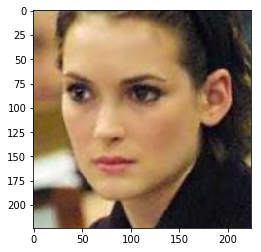

In [56]:
with h5py.File('preprocessed_faces.mat', 'r') as f:
    data = np.array(f.get('mat'))
print(data.shape)
dataT = data.transpose((3, 2, 1, 0))
print (dataT.shape)
plt.imshow(np.uint8(np.squeeze(dataT[0])))

In [73]:
def get_descriptors(model, data):    
    descriptors = model.predict(data, verbose=1)
    return np.squeeze(descriptors)

In [74]:
# Prediction with nearest-k neighbors and cosine similarity
def predict(train_descriptors, test_descriptors, k, num_examples_per_face, threshold=None):
    predictions = []
   
    for d in test_descriptors:
        # Use cosine similarity
        distances = [cosine(train_descriptors[i], d) for i in range(len(train_descriptors))]
        
        # The closest k vote instead of average
        closest_k = np.asarray(distances).argsort()[:k] // num_examples_per_face
        predictions.append(mode(closest_k).mode)
    return np.asarray(predictions).flatten()

# Alternative prediction method with average and L2 Euclidean distance
def predict_with_mean(train_descriptors, test_descriptors, num_examples_per_face, threshold=None):
    predictions = []
    mean_train_descriptors = np.mean(np.reshape(train_descriptors, (-1, num_examples_per_face, 4096)), axis=1)
   
    for d in test_descriptors:
        distances = [np.linalg.norm(mean_train_descriptors[i] - d) for i in range(len(mean_train_descriptors))]
        predictions.append(np.argmin(distances))
    return np.asarray(predictions)

In [75]:
def run_experiment(manipulation_info: ManipulationInfo):
    print('Loading model')
    model = partial_vgg_face()
    
    print('Loading dataset')
    min_faces_per_person = 20
    train_data, train_targets, test_data, test_targets = get_lfw_dataset(
        min_faces_per_person, manipulation_info=manipulation_info)
    
    # Train
    print('Training')
    time1 = time.clock()
    num_faces = len(np.unique(train_targets))
    num_examples_per_face = int(len(train_targets) / num_faces)
    train_descriptors = get_descriptors(model, train_data)
    test_descriptors = get_descriptors(model, test_data)
    time2 = time.clock()
    train_time = time2 - time1
    
    # Test
    print('Testing')
    time1 = time.clock()
    train_predictions_1 = predict(train_descriptors, train_descriptors, 1, num_examples_per_face)
    train_predictions_3 = predict(train_descriptors, train_descriptors, 3, num_examples_per_face)
    train_predictions_5 = predict(train_descriptors, train_descriptors, 5, num_examples_per_face)
    train_predictions_7 = predict(train_descriptors, train_descriptors, 7, num_examples_per_face)
    # train_accuracy = experiment.compute_accuracy(train_predictions, test_targets)
    train_accuracy_1 = experiment.compute_accuracy(train_predictions_1, train_targets)
    train_accuracy_3 = experiment.compute_accuracy(train_predictions_3, train_targets)
    train_accuracy_5 = experiment.compute_accuracy(train_predictions_5, train_targets)
    train_accuracy_7 = experiment.compute_accuracy(train_predictions_7, train_targets)
    
    # Predict test_descriptors
    test_predictions_1 = predict(train_descriptors, test_descriptors, 1, num_examples_per_face)
    test_predictions_3 = predict(train_descriptors, test_descriptors, 3, num_examples_per_face)
    test_predictions_5 = predict(train_descriptors, test_descriptors, 5, num_examples_per_face)
    test_predictions_7 = predict(train_descriptors, test_descriptors, 7, num_examples_per_face)
    # test_accuracy = experiment.compute_accuracy(test_predictions, test_targets)
    test_accuracy_1 = experiment.compute_accuracy(test_predictions_1, test_targets)
    test_accuracy_3 = experiment.compute_accuracy(test_predictions_3, test_targets)
    test_accuracy_5 = experiment.compute_accuracy(test_predictions_5, test_targets)
    test_accuracy_7 = experiment.compute_accuracy(test_predictions_7, test_targets)
    time2 = time.clock()
    test_time = time2 - time1
    
    train_accuracy = { "k=1": train_accuracy_1, 
                      "k=3": train_accuracy_3, 
                      "k=5": train_accuracy_5, 
                      "k=7": train_accuracy_7 }
    
    test_accuracy = { "k=1": test_accuracy_1, 
                      "k=3": test_accuracy_3, 
                      "k=5": test_accuracy_5, 
                      "k=7": test_accuracy_7 }
    
    # Print results.
    num_faces = len(np.unique(train_targets))
    model_name = 'VGG_FACE'
    print("Manipulation info: %s" % str(manipulation_info))
    print("Recognition Algorithm: %s" % model_name)
    print("Number of distinct faces: %d" % num_faces)
    print("Chance rate: %f" % (1 / num_faces))
    print("Train accuracy: %s" % train_accuracy)
    print("Test accuracy: %s" % test_accuracy)
    print("Training Time: %s sec" % train_time)
    print("Testing Time: %s sec" % test_time)
    print("\n")

    
    return {
        "Manipulation Type": manipulation_info.type,
        "Manipulation Parameters": manipulation_info.parameters,
        "Recognition Algorithm": model_name,
        "Min Faces Per Person": min_faces_per_person,
        "Number of Distinct Faces": num_faces,
        "Chance Rate": (1 / num_faces),
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Training Time": train_time,
        "Testing Time": test_time,
    }

In [80]:
manipulation_infos = [
        ManipulationInfo("none", {}),
        ManipulationInfo("occlude_lfw", {"occlusion_size": 82}), # Adjusted for new image size
        ManipulationInfo("occlude_lfw", {"occlusion_size": 41}),
        ManipulationInfo("occlude_lfw", {"occlusion_size": 124}),
        ManipulationInfo("occlude_lfw", {"occlusion_size": 165}),
        ManipulationInfo("radial_distortion", {"k": 0.000008}), # Adjusted for new image size
        ManipulationInfo("radial_distortion", {"k": -0.000008}),
        ManipulationInfo("radial_distortion", {"k": 0.000016}),
        ManipulationInfo("radial_distortion", {"k": -0.000016}),
        ManipulationInfo("radial_distortion", {"k": 0.00003}),
        ManipulationInfo("radial_distortion", {"k": -0.00003}),
        ManipulationInfo("blur", {"blurwindow_size": 5}),
        ManipulationInfo("blur", {"blurwindow_size": 10})
    ]

for manipulation in manipulation_infos:
    stats = run_experiment(manipulation)
    print(stats)
    print()

Loading model
Loading dataset
Training
2837/2837 [==============================] - 1189s 419ms/step
Testing
Manipulation info: ManipulationInfo(type='none', parameters={})
Recognition Algorithm: VGG_FACE
Number of distinct faces: 62
Chance rate: 0.016129
Train accuracy: {'k=1': 1.0, 'k=3': 0.9838709677419355, 'k=5': 0.95161290322580649, 'k=7': 0.84408602150537637}
Test accuracy: {'k=1': 0.96686640817765246, 'k=3': 0.96263658794501239, 'k=5': 0.94360239689813186, 'k=7': 0.9002467395135707}
Training Time: 2495.0306659999987 sec
Testing Time: 142.46391900000162 sec


{'Manipulation Type': 'none', 'Manipulation Parameters': {}, 'Recognition Algorithm': 'VGG_FACE', 'Min Faces Per Person': 20, 'Number of Distinct Faces': 62, 'Chance Rate': 0.016129032258064516, 'Train Accuracy': {'k=1': 1.0, 'k=3': 0.9838709677419355, 'k=5': 0.95161290322580649, 'k=7': 0.84408602150537637}, 'Test Accuracy': {'k=1': 0.96686640817765246, 'k=3': 0.96263658794501239, 'k=5': 0.94360239689813186, 'k=7': 0.9002467

Loading dataset
Training
2837/2837 [==============================] - 1188s 419ms/step
Testing
Manipulation info: ManipulationInfo(type='radial_distortion', parameters={'k': 1.6e-05})
Recognition Algorithm: VGG_FACE
Number of distinct faces: 62
Chance rate: 0.016129
Train accuracy: {'k=1': 1.0, 'k=3': 0.9838709677419355, 'k=5': 0.95161290322580649, 'k=7': 0.84408602150537637}
Test accuracy: {'k=1': 0.92562566090941134, 'k=3': 0.92527317589002467, 'k=5': 0.90729643990130415, 'k=7': 0.86041593232287628}
Training Time: 2493.499229000001 sec
Testing Time: 142.83027000000584 sec


{'Manipulation Type': 'radial_distortion', 'Manipulation Parameters': {'k': 1.6e-05}, 'Recognition Algorithm': 'VGG_FACE', 'Min Faces Per Person': 20, 'Number of Distinct Faces': 62, 'Chance Rate': 0.016129032258064516, 'Train Accuracy': {'k=1': 1.0, 'k=3': 0.9838709677419355, 'k=5': 0.95161290322580649, 'k=7': 0.84408602150537637}, 'Test Accuracy': {'k=1': 0.92562566090941134, 'k=3': 0.92527317589002467, 'k=5': 0

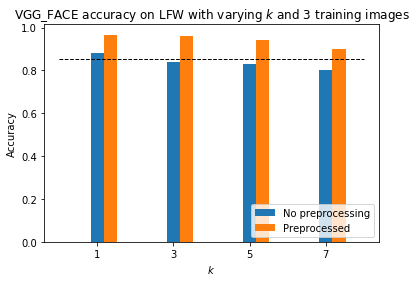

In [90]:
# Graphs

# Accuracy as a function of k for 3 training images
# With and without preprocessing
# Mean/Euclidean distance included as a line

accuracy = np.array([0.8808600634473035, 0.83785689108212902, 0.83080719069439546, 0.79978850898836795])
preprocessed_accuracy = np.array([0.96686640817765246, 0.96263658794501239, 0.94360239689813186, 0.9002467395135707])
k = np.array([1, 3, 5, 7])

fig, ax = plt.subplots()
width = 0.35
acc1 = ax.bar(k, accuracy, width, label='No preprocessing')
acc2 = ax.bar(k+width, preprocessed_accuracy, width, label='Preprocessed')
ax.plot([0, 8], [0.85442368699330273, 0.85442368699330273], 'k-', lw=1, linestyle='dashed')
ax.set_xticks(k)
ax.set_xlabel('$k$')
ax.set_ylabel('Accuracy')
ax.set_title('VGG_FACE accuracy on LFW with varying $k$ and 3 training images')
legend = ax.legend(handles=[acc1, acc2], loc=4)
plt.show()